# Algorithmes de descente en optimisation différentiable sans contrainte
## Fichier de correction
### Alban Gossard (gossard@insa-toulouse.fr)

Mettez ci-dessous les imports classiques de librairie Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Dans ce TP, nous nous intéressons aux algorithmes pour la minimisation sans contrainte de fonctionnelles très générales: le problème s'écrit:

$$\min_{x\in\mathbb{R}^n} f(x).$$

Le but de cette séance est l'écriture d'un code de minimisation locale, et l'évaluation de ses performances sur les fonctions tests suivantes:

<li>$f_1(x,y) = 2(x+y-2)^2+(x-y)^2$.
<li>$f_2(x,y) = 100(y-x^2)^2 + (1-x)^2$ (fonction de Rosenbrock).

On appelle $\textit{oracle}$ une routine qui à un $x$ donné, renvoie la valeur $f(x)$ du critère, le gradient $\nabla f(x)$ (ou une approximation du gradient) s'il existe, et éventuellement la matrice Hessienne $H[f](x)$ (ou une approximation) si elle existe et si nécessaire:

$$[f(x),\nabla f(x),H[f](x)] = \textrm{oracle}(x)$$

> **A faire :** Calculer les gradients et les Hessiennes des deux fonctions proposées et implémenter les fonctions $\textrm{oracle}$ correspondantes.

>**Réponse :** *On trouve les gradients
$$\nabla f_1(x) = \begin{pmatrix}6x+2y-8\\6y+2x-8\end{pmatrix} \quad\mbox{ et }\quad \nabla f_2(x) = \begin{pmatrix}400(x^3-yx)+2(x-1)\\200(y-x^2)\end{pmatrix}.$$
Ainsi que les hessiennes
$$H[f_1](x) = \begin{pmatrix}6&2\\2&6\end{pmatrix} \quad\mbox{ et }\quad H[f_2](x) = \begin{pmatrix}1200x^2 - 400y + 2 & -400x\\-400x&200\end{pmatrix} .$$* 

In [2]:
def oracle1(x):
    # Renvoie la valeur de la fonction f_1 (scalaire), son gradient (array de taille 2), et sa hessienne (array de taille 2x2)
    # x: array de taille 2, correspond au point d'évaluation de la fonction f_1
    f= 2.*(x[0]+x[1]-2.)**2.+(x[0]-x[1])**2.
    df=np.array([6*x[0]+2.*x[1]-8, 6*x[1]+2*x[0]-8])
    Hf=np.array([[6,2],[2,6]])
    return f,df,Hf

def oracle2(x):
    # Renvoie la valeur de la fonction f_2 (scalaire), son gradient (array de taille 2), et sa hessienne (array de taille 2x2)
    # x: array de taille 2, correspond au point d'évaluation de la fonction f_2
    f= 100.*(x[1]-x[0]**2.)**2.+(1.-x[0])**2.
    df=np.array([400*(x[0]**3.-x[1]*x[0])+2*(x[0]-1), 200*(x[1]-x[0]**2.)])
    Hf=np.array([[1200*x[0]**2.-400*x[1]+2.,-400*x[0]],[-400*x[0],200]])
    return f,df,Hf

On rappelle qu'un algorithme de descente appliqué à la minimisation de $f$ possède la forme suivante:

* **Données :** $x_0\in \mathbb{R}^n$ point initial arbitraire, un oracle.
* **Initialisation :** Numéro d'itération: $k=0$.
* **Tant que** le critère d'arrêt n'est pas satisfait, **faire**
  * Calcul de la direction de descente $d_k$.
  * Choix/Calcul du pas $s_k$.
  * Mise à jour: calcul du prochain itéré $x_{k+1}$.
  * $k = k + 1.$

> **A faire :** Résolution mathématique:

1. Donner les points critiques des fonctions proposées.
2. Les fonctions $f_i$ admettent-elles des extrema sur $\mathbb{R}^2$?

>**Réponse :** *Les points critiques $x^*_i\in\mathbb{R}^2$, $i\in\{1,2\},$ des fonctions $f_i$ vérifie
$$\nabla f_1(x^\star_1) = 0 \quad \Leftrightarrow \quad x^\star_1 = \begin{pmatrix} 1\\1 \end{pmatrix},$$
et
$$\nabla f_2(x^\star_2) = 0 \quad \Leftrightarrow \quad x^\star_2 = \begin{pmatrix} 1\\1 \end{pmatrix}.$$
On remarque que
$$\det(H[f_1](x^\star_1)) = \det\begin{pmatrix}6&2\\2&6\end{pmatrix}=32>0 \quad\mbox{ et }\quad \textrm{Tr}(H[f_1](x^\star_1)) = 12>0,$$
donc $x^\star_1$ est un minimum localde la fonction $f_1$.
De même, sachant que
$$\det(H[f_2](x^\star_2)) = \begin{pmatrix}802 & -400\\-400&200\end{pmatrix} = 400\quad\mbox{ et }\quad \textrm{Tr}(H[f_2](x^\star_2)) >0,$$
on déduit que $x^\star_2$ est un minimum local.
Les minimums sont même globaux car les fonctions $f_i$ sont $\ge 0$ et sont nulles en $x_i^\star$*

> **A faire :** Implémenter deux algorithmes de mimimisation, un par méthode de gradient à pas fixe et l'autre par une méthode de Newton locale. Les arguments d'entrée sont $\textrm{function}$ qui est l'oracle à minimiser, $\textrm{xini}$ qui est le point initial et $\textrm{h}$ qui est le pas de la méthode de gradient. Les arguments de sortie sont $\textrm{x}$ la valeur finale du point trouvée, $\textrm{xiter}$ qui est la valeur du point au cours des itérations et $\textrm{iter}$ le nombre d'itérations pour arriver à convergence.

In [3]:
def Gradient(function,h=1e-1,xini=np.array([0,0]), verbose=True):
    # Fonction d'optimisation par descente de gradient à pas fixe
    # function: fonction à évaluer
    # h:        pas de la méthode (scalaire), valeur pas défaut: 0.1
    # xini:     point de départ de la méthode d'optimisation, valeur par défaut: (0,0)
    # verbose:  booléen indiquant si l'algorithme doit afficher les itérations (utile pour pouvoir facilement désactiver les affichages), valeur par défaut: True
    # Renvoie la solution (dernière itération), l'historique de toutes les itérés et le nombre d'itérations effectuées
    x=np.copy(xini)
    f,grad,_ = function(x)       # on récupère la valeur de la fonction et son gradient, ici nous n'avons pas besoin de la hessienne
    niter=0
    xiter=[]
    while np.linalg.norm(grad)>1e-6: # on prend le critère d'arrêt sur la norme du gradient
        if verbose:
            print('Iter '+str(niter)+'\t x='+str(x)+'\t f='+str(f))
        x=x-h*grad               # descente de gradient
        xiter.append(x)          # on enregistre les itérés
        f, grad, _ = function(x) # on ré-évalue la fonction
        niter+=1
    return x,xiter,niter

In [4]:
def Newton(function,xini=[0,0], verbose=True):
    # Fonction d'optimisation par méthode de Newton
    # function: fonction à évaluer
    # xini:     point de départ de la méthode d'optimisation, valeur par défaut: (0,0)
    # verbose:  booléen indiquant si l'algorithme doit afficher les itérations (utile pour pouvoir facilement désactiver les affichages), valeur par défaut: True
    # Renvoie la solution (dernière itération), l'historique de toutes les itérés et le nombre d'itérations effectuées
    x=np.copy(xini)
    f,grad,hess = function(x)     # on récupère la valeur de la fonction, son gradient et sa hessienne
    niter=0
    xiter=[]
    while np.linalg.norm(grad)>1e-6: # on prend le critère d'arrêt sur la norme du gradient
        if verbose:
            print('Iter '+str(niter)+'\t x='+str(x)+'\t f='+str(f))
        d=np.linalg.solve(hess,-grad) # à chaque itération on résout un système linéaire pour calculer la direction
        x=x+d
        xiter.append(x)
        f,grad,hess = function(x) # on ré-évalue la fonction
        niter+=1
    return x,xiter,niter

> **A faire :** En utilisant le module $\textrm{matplotlib.pyplot}$, on veut représenter/dessiner la suite des itérés dans $\mathbb{R}^2$ avec la fonction $\textrm{scatter}$.On souhaite aussi représenter les fonctions $f_1$ et $f_2$ en utilisant la fonction $\textrm{contour}$ du module $\textrm{matplotlib.pyplot}$. On s'inspirera du code qui suit pour créer deux fonctions (une pour chaque oracle) $\textrm{affichage1(xiter)}$ et $\textrm{affichage2(xiter)}$ qui affiche représente les itérations.

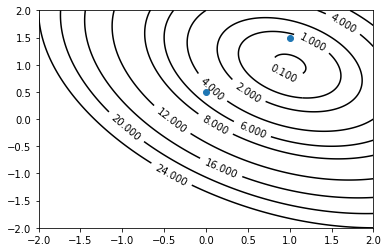

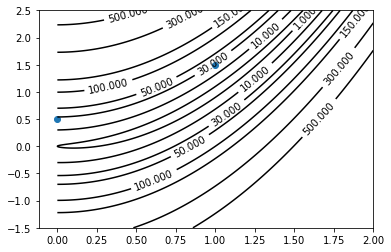

In [5]:
def affichage1(xiter):
    Nx = 1000
    Ny = 1000
    x = np.linspace(-2,2,Nx)
    y = np.linspace(-2,2,Ny)
    X, Y = np.meshgrid(x, y)
    Z = 2.*(X+Y-2.)**2.+(X-Y)**2.
    CS=plt.contour(X, Y, Z,[0,0.1,1,2,4,6,8,12,16,20,24],colors='k')
    plt.clabel(CS, inline=1, fontsize=10)
    xiter=np.array(xiter)
    plt.scatter(xiter[:,0],xiter[:,1],marker='o')
    plt.show()
def affichage2(xiter):
    Nx = 1000
    Ny = 1000
    x = np.linspace(0,2,Nx)
    y = np.linspace(-1.5,2.5,Ny)
    X, Y = np.meshgrid(x, y)
    Z = 100.*(Y-X**2.)**2.+(1.-X)**2.
    CS=plt.contour(X, Y, Z,[0,1,10,30,50,100,150,300,500],colors='k')
    plt.clabel(CS, inline=1, fontsize=10)
    xiter=np.array(xiter)
    plt.scatter(xiter[:,0],xiter[:,1],marker='o')
    plt.show()

z = [[1,1.5],[0,0.5]]
affichage1(np.array(z))
plt.show()
affichage2(np.array(z))
plt.show()

Tester la méthode de Newton et la méthode de gradient pour différents points de départ et différents pas pour la fonction oracle1. Conclure


Gradient function 1
Iter 0	 x=[0 0]	 f=8.0
Iter 1	 x=[0.8 0.8]	 f=0.31999999999999984
Iter 2	 x=[0.96 0.96]	 f=0.012800000000000023
Iter 3	 x=[0.992 0.992]	 f=0.000512000000000001
Iter 4	 x=[0.9984 0.9984]	 f=2.0480000000001173e-05
Iter 5	 x=[0.99968 0.99968]	 f=8.191999999999332e-07
Iter 6	 x=[0.999936 0.999936]	 f=3.276799999995186e-08
Iter 7	 x=[0.9999872 0.9999872]	 f=1.3107200000071692e-09
Iter 8	 x=[0.99999744 0.99999744]	 f=5.2428799999377274e-11
Iter 9	 x=[0.99999949 0.99999949]	 f=2.097151999611293e-12
Iter 10	 x=[0.9999999 0.9999999]	 f=8.388608005721129e-14
[0.99999998 0.99999998] [array([0.8, 0.8]), array([0.96, 0.96]), array([0.992, 0.992]), array([0.9984, 0.9984]), array([0.99968, 0.99968]), array([0.999936, 0.999936]), array([0.9999872, 0.9999872]), array([0.99999744, 0.99999744]), array([0.99999949, 0.99999949]), array([0.9999999, 0.9999999]), array([0.99999998, 0.99999998])] 11


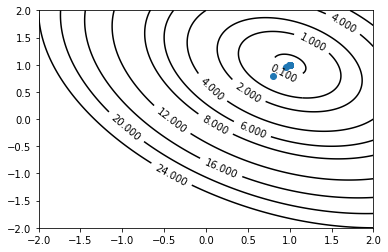


Newton function 1
Iter 0	 x=[0 0]	 f=8.0
[1. 1.] [array([1., 1.])] 1


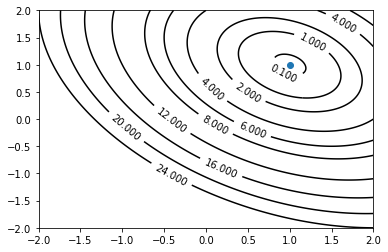

In [6]:
# Ce que l'on doit conclure:
# Le pas dans la méthode de descente de gradient est très important !
#  - un pas trop grand fait diverger la méthode
#  - un pas trop petit fait converger la méthode trèèèèès lentement
# La méthode de Newton "prend en compte" la courbure de la fonction, évite de tomber dans des vallées et de faire des oscillations
# Les inconvénients de la méthode de Newton:
#  - il faut avoir accès à la hessienne de la fonction
#  - à chaque itération il faut résoudre un système linéaire, cela n'est pas embêtant ici car la fonction dépend de 2 variables seulement

print("\nGradient function 1")
x,xiter,niter = Gradient(oracle1)
print(x,xiter,niter)
affichage1(xiter)

print("\nNewton function 1")
x,xiter,niter = Newton(oracle1)
print(x,xiter,niter)
affichage1(xiter)


Gradient function 2
Iter 0	 x=[0 0]	 f=1.0
Iter 1	 x=[0.2 0. ]	 f=0.8000000000000003
Iter 2	 x=[0.04 0.8 ]	 f=64.66585600000003
Iter 3	 x=[  1.50944 -15.168  ]	 f=30437.978625024105
Iter 4	 x=[-1051.9647589    333.76018227]	 f=122389105819928.53
Iter 5	 x=[4.65513793e+10 2.21262556e+07]	 f=4.69602298585082e+44
Iter 6	 x=[-4.03513112e+33  4.33406183e+22]	 f=2.651127455336414e+136
Iter 7	 x=[2.62804590e+102 3.25645664e+068]	 f=inf
[           -inf 1.38132506e+206] [array([0.2, 0. ]), array([0.04, 0.8 ]), array([  1.50944, -15.168  ]), array([-1051.9647589 ,   333.76018227]), array([4.65513793e+10, 2.21262556e+07]), array([-4.03513112e+33,  4.33406183e+22]), array([2.62804590e+102, 3.25645664e+068]), array([           -inf, 1.38132506e+206])] 8


/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


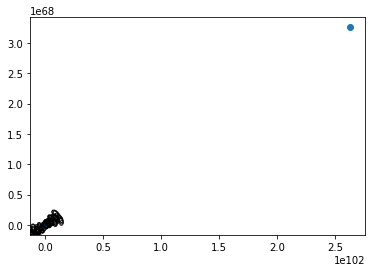


Newton function 2
Iter 0	 x=[0 0]	 f=1.0
Iter 1	 x=[1. 0.]	 f=100.0
[1. 1.] [array([1., 0.]), array([1., 1.])] 2


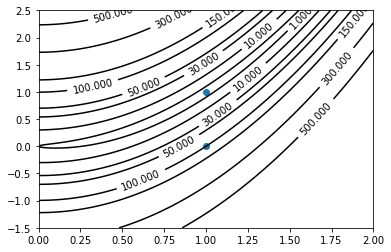

In [7]:
print("\nGradient function 2")
x,xiter,niter = Gradient(oracle2)
print(x,xiter,niter)
affichage2(xiter)

print("\nNewton function 2")
x,xiter,niter = Newton(oracle2)
print(x,xiter,niter)
affichage2(xiter)

## Test de différentes initialisations


Gradient function 1
x0= [-1  0]


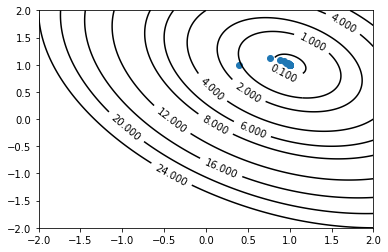

x0= [ 0 -1]


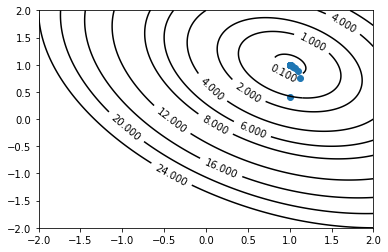

x0= [-10  10]


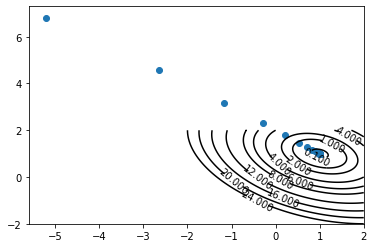


Newton function 1
x0= [-1  0]


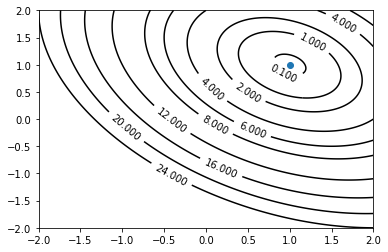

x0= [ 0 -1]


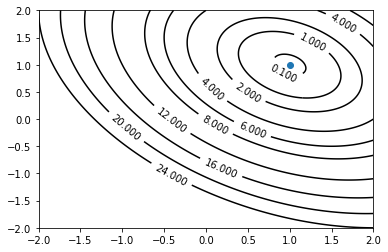

x0= [-10  10]


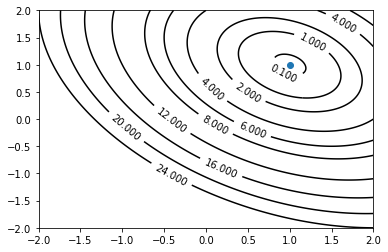

In [8]:
list_x0=[np.array([-1,0]),np.array([0,-1]),np.array([-10,10])]

print("\nGradient function 1")
for x0 in list_x0:
    print('x0=',x0)
    x,xiter,niter = Gradient(oracle1, xini=x0, verbose=False)
    affichage1(xiter)

print("\nNewton function 1")
for x0 in list_x0:
    print('x0=',x0)
    x,xiter,niter = Newton(oracle1, xini=x0, verbose=False)
    affichage1(xiter)

## Test de différents pas


Gradient function 1
h= 0.0001


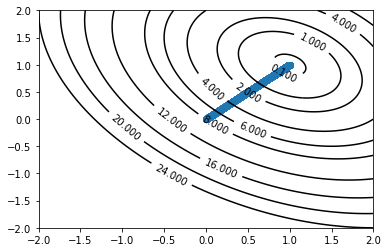

h= 0.001


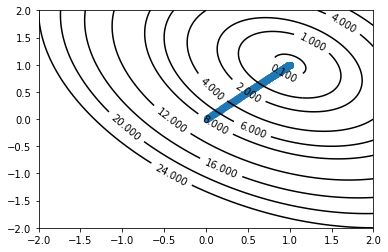

h= 0.01


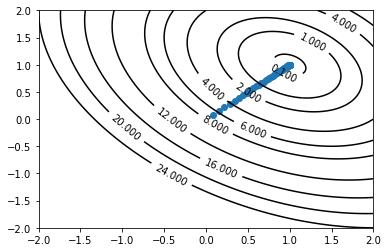

h= 0.1


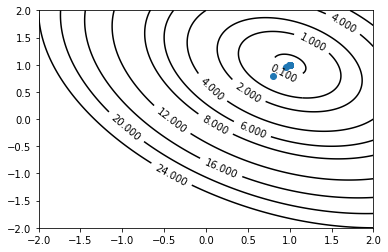

h= 1.0


/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """
/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app


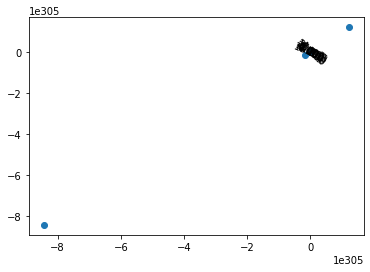


Gradient function 2
h= 0.0001


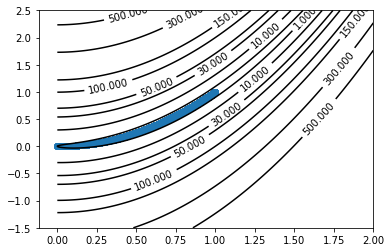

h= 0.001


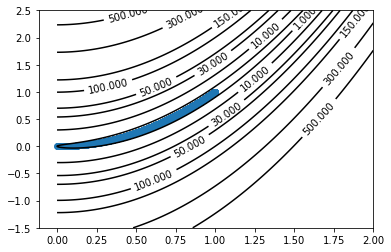

h= 0.01


/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/agossard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


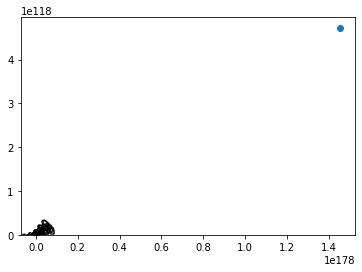

h= 0.1


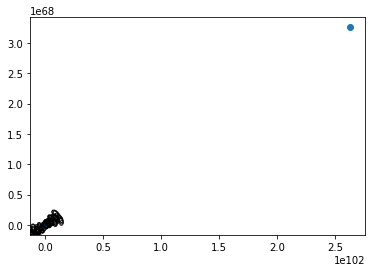

h= 1.0


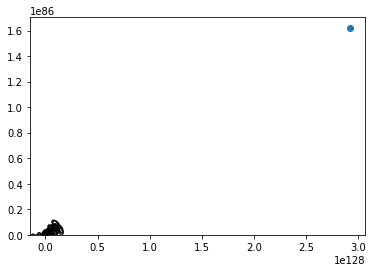

In [9]:
list_h=np.logspace(-4,0,5)

print("\nGradient function 1")
for h in list_h:
    print('h=',h)
    x,xiter,niter = Gradient(oracle1, h=h, verbose=False)
    affichage1(xiter)
print("\nGradient function 2")
for h in list_h:
    print('h=',h)
    x,xiter,niter = Gradient(oracle2, h=h, verbose=False)
    affichage2(xiter)
